In [1]:
%load_ext autoreload
%autoreload 2

In [84]:
# your function must import layout and constants
# this is structured to work both in Jupyter notebook and from the command line
try:
    from . import layout
    from . import constants
except ImportError:
    import layout
    import constants
    
from time import time
import logging
from urllib.parse import quote
import shutil
from pathlib import Path
import re
import json
from os import path
import json


import requests
from dictor import dictor
from datetime import datetime
import pytz

    


In [3]:
def get_coord(*args, print_response=True, **kwargs):
    '''USER FACING HELPER FUNCTION:
    lookup and my_print the latitude, longitude of a place given as a string:
    
    usage: --run_plugin_func moon_phase.get_coord "Cotu, Provence, Country"
    
    --run_plugin_func moon_phase.get_coord "Morrison, Colorado, USA"
    >>> Morrison, Jefferson County, Colorado, 80465, United States
    Morrison, Colorado, USA:
    lat: 39.642
    lon: -105.193
    ('39.6422', '-105.19332324506902')
    
    Args:
        place(`str`): "City, Provence, Country
    
    Returns:
        `tuple`: lat, lon
        
    Example:
        get_coord("Denver, Colorado, USA")
        get_coord("Bamako, Mali")
        %U'''
    def my_print(args):
        if print_response:
            print(args)
        else:
            pass
    if args:
        place = args[0]
    elif 'place' in kwargs:
        place = kwargs['place']
    else:
        place = None
    
    
    
    lat, lon = None, None
    if not place:
        my_print('lookup the lat/lon of city, town or geographic area')
        my_print('usage: moon_phase.get_coord "City, Area, Country"')
        my_print('moon_phase.get_coord "Golden Colorado, USA"')
        my_print("""\nGolden, Jefferson County, Colorado, 80401, United States
Golden Colorado, USA:
lat: 39.756
lon: -105.221
('39.755543', '-105.221099')""")
        return (lat, lon)
    
    osm_endpoint = constants.osm_endpoint
    osm_query = constants.osm_query
    place_quote = quote(place)
    url = f'{osm_endpoint}{place_quote}{osm_query}'
    try:
        result = requests.get(url)
    except requests.RequestException as e:
        logging.warning(f'could not process request: {e}')
    if result.status_code == 200:
        if len(result.json()) > 0:
            lat = dictor(result.json()[0], 'lat')
            lon = dictor(result.json()[0], 'lon')
            display_name = dictor(result.json()[0], 'display_name')
            my_print(f'{display_name}\n{place}:\nlat: {float(lat):.3f}\nlon: {float(lon):.3f}')
        else:
            my_print(f'no data was returned for place: {place}')
            my_print(f'check the spelling or try a more general query')
    else:
        my_print(f'No valid data was returned: status_code: {result.status_code}')
    
    return(lat, lon)    

In [4]:
def list_country_locales(country=None):
    '''USER FACING HELPER FUNCTION:
    Print the known timezones for a country specified 
    with two letter country code:
    
    usage: 
    --run_plugin_func moon_phase.list_country_locales <ISO 3166 Country Code>
    
    --run_plugin_func moon_phase.list_country_locales NZ
    >>> ['Pacific/Auckland', 'Pacific/Chatham']
    
    Args:
        country(`str`): two letter ISO 3166 country code
    
    %U'''
    if not country:
        print('No country code provided.')
        print('Specify one of the known ISO 3116 country codes:')
        cc = [i for i in pytz.country_names]
        _col_print(cc, term_width=60)
    
    else:
        try:
            print(pytz.country_timezones[country])
        except KeyError as e:
            print('Unknown country code. Try again with no country code to see a full list')
    


In [5]:
def _get_offset(timezone):
    '''return an offset of a pytz timezone in Region/Locale as +/-HH:MM format
    
    use function list_country_offsets() to find the known Region/Locales 
        
    Example: _get_offset("Pacific/Fiji")
    >>> +13:00
        
    Args: 
        timezone(`str`): Region/Locale 
        
    Returns:
        `str` +/- HH:MM format '''
    offset = datetime.now(pytz.timezone(timezone)).strftime('%z')
    offset_hhmm = f'{offset[0:3]}:{offset[3:]}'
    return offset_hhmm

In [91]:
def _col_print(lines, term_width=None, indent=0, pad=2):
    '''print list in columns dependent on the term_width value
    
    Args:
        lines(`list`): one dimensional list
        term_width(`int`): width of terminal in columns
        indent(`int`): characters to indent
        pad(`int`): padding between columns
        
    https://gist.github.com/critiqjo/2ca84db26daaeb1715e1'''
    
    if not term_width:
        size = shutil.get_terminal_size((80, 20))
        term_width = size.columns
    n_lines = len(lines)
    if n_lines == 0:
        return

    col_width = max(len(line) for line in lines)
    n_cols = int((term_width + pad - indent)/(col_width + pad))
    n_cols = min(n_lines, max(1, n_cols))

    col_len = int(n_lines/n_cols) + (0 if n_lines % n_cols == 0 else 1)
    if (n_cols - 1) * col_len >= n_lines:
        n_cols -= 1

    cols = [lines[i*col_len : i*col_len + col_len] for i in range(n_cols)]

    rows = list(zip(*cols))
    rows_missed = zip(*[col[len(rows):] for col in cols[:-1]])
    rows.extend(rows_missed)

    for row in rows:
        print(" "*indent + (" "*pad).join(line.ljust(col_width) for line in row))

In [119]:
def _process_data(data):
    
    def get_value(my_data, key, address, default=None):
        success = True
        value = None
        
        try:
            my_dict = dictor(my_data, address)
            value = my_dict[key]
        except KeyError as e:
            logging.error(f'KeyError: {address}.{e} not found in API data')
            success = False
        except TypeError as e:
            logging.error(f'No valid data found in API data')
            logging.debug(f'API Data: {data}')
            
        if default and not success:
            logging.warning(f'failed to set data, returning default value: {default}')
            value = default            
        
        return value
    
    def convert_time(dt_str, dt_format='%H:%M'):
        try:
            dt_obj = datetime.strptime(dt_str, '%Y-%m-%dT%H:%M:%S%z')
            converted = datetime.strftime(dt_obj, dt_format)
        except (ValueError, TypeError) as e:
            logging.warning('could not convert time string')
            converted = None
        return converted
    
    temp_data = {}
    rise_str = get_value(data, 'time', constants.addr_rise, default='None')
    temp_data['moonrise'] = convert_time(rise_str)
    
    set_str = get_value(data, 'time', constants.addr_set, default='None')
    temp_data['moonset'] = convert_time(set_str)
    
    try:
        phase_float = get_value(data, 'value', constants.addr_phase, default=0)
        phase_float = float(phase_float)
    except ValueError as e:
        logging.error(f'cannot obtain float for: {phase_float}')
        phase_float = 0
    temp_data['phase_value'] = round(phase_float, 1)
    
    age = (29.5 * (phase_float/100))
    temp_data['age'] = round(age, 1)
    
    temp_data['image_file'] = Path(f'{constants.image_path}/{temp_data["phase_value"]}{constants.img_suffix}')
    
    phase_string = get_value(data, 'desc', constants.addr_phase, default='None')
    # search for description: 'LOCAL MOON STATE * MOON PHASE= 28.0 (waxing gibbous)'
    match = re.search( '.*\((.*)\)', phase_string)
    

    
    try:
        desc = match.group(1).title()
    except AttributeError:
        logging.warning(f'no description found in supplied string: {s}')
        desc = 'None'
    finally:
        temp_data['phase_desc'] = desc
    

        for each, value in constants.data_template.items():
            try:
                temp_data[each] = value.format(temp_data[each])
            except KeyError as e:
                logging.error(f'error processing key: {each}')
                temp_data[each] = value.format('None')
    
    return temp_data

In [141]:
# make sure this function can accept *args and **kwargs even if you don't intend to use them
def update_function(self, *args, **kwargs):
    '''update function for moon_phase plugin provides an image of the moon and moon data for a location
    
    This plugin provides the following information:
    
     * Accurate image of the moon at moon rise
     * Moon Rise time at location
     
    
    Configuration Requirements:
        self.config(dict): {
            'location_name': 'Europe/Amsterdam', 
            'email': Your_Email@some.domain,
            'lat': xx.yy,     # this is optional, but will provide more accuracy
            'lon': -ss.qq,    # this is optional, but will provide more accuracy
        }
        
    Args: 
        self.cache(`CacheFiles` object)
        
    Args:
        self(namespace): namespace from plugin object
    
    Returns:
        tuple: (is_updated(bool), data(dict), priority(int))
        
    
    Images are sourced from of NASA's Scientific Visualization sutudio: https://svs.gsfc.nasa.gov/4955#32006
    and represent the first full lunar month of 2022.
    
    Moonrise data is sourced from the Meteorologisk Institutt of Norway: 
    https://api.met.no/weatherapi/sunrise/2.0/documentation#!/data/get
            
    %U'''   
    
    is_updated = False
    data = {}
    priority = self.max_priority +1
    
    failure = (is_updated, data, priority)

    required_config_options = constants.required_config_options
    
    json_file = self.cache.path/constants.json_file
    json_data = None
    
    
    # check the passed in configuration
    if hasattr(self, 'configured'):
        pass
    else:
        # if add any missing configuration keys
        for k, v in required_config_options.items():
            if not k in self.config:
                logging.debug(f'missing config value: {k}')
                logging.debug(f'using config value: {v}')
                self.config[k] = v
        if self.config['email']:
            self.config['user_agent'] = f'{constants.name}, v{constants.version} -- {self.config["email"]}'
        else:
            logging.warning('missing email address in configuration file -- cannot create user agent string')
            self.config['user_agent'] = None
            
        # set lat/lon based on the region/locale data 
        if not (self.config['lat'] and self.config['lon']):
            logging.info(f'no lat/lon provided, guessing based on {self.config["location_name"]}')
            self.config['lat'], self.config['lon'] = get_coord(self.config['location_name'], print_response=False)
        
        # set the UTC offset based on the location name
        try:
            self.config['offset'] = _get_offset(self.config['location_name'])
        except UnknownTimeZoneError as e:
            logging.error(f'unknown location: {self.config["location_name"]}')
            logging.error(f'using default location: {constants.required_config_options["location_name"]}')
            
        self.configured = True
        

    # build a header see: https://api.met.no/weatherapi/locationforecast/2.0/documentation#AUTHENTICATION
    if self.config['user_agent']:
        user_agent = self.config['user_agent']
        logging.debug(f'user_agent string: {user_agent}')
    else:
        logging.warning('no user-agent string available -- cannot complete request')
        return failure
        
    headers = {'User-Agent': user_agent, 
              'From': self.config['email']}
    
    param = {
        'lat': self.config['lat'],
        'lon': self.config['lon'],
        'date': datetime.now().strftime('%Y-%m-%d'),
        'offset': self.config['offset']}
        
    # get the mtime of the cached json file
    logging.debug(f'checking mtime of cached json file: {json_file}')
    try:
        mtime  = time() - path.getmtime(json_file)
        logging.debug(f'age of {json_file}: {mtime}')
    except OSError as e:
        logging.info(f'{e}')
        mtime = 2**16
    except json.JSONDecodeError as e:
        logging.info(f'{e}')
        mtime = 2**16
        
    
    if json_file.exists() and mtime < constants.json_max_age:
        try:
            logging.debug('using cached met.no data')
            with open(json_file) as jf:
                json_data = json.load(jf)
        except OSError as e:
            logging.warning(f'could not open cached JSON file: {e}')
        except json.JSONDecodeError as e:
            logging.error(f'could not decode JSON file: {e}')
            json_data = None
    else:
        json_data = None
            
    
    if not json_data:
        # make the request
        try:
            logging.debug('downloading fresh data from met.no API')
            sunrise = requests.get(constants.met_endpoint, param, headers=headers)
        except RequestException as e:
            logging.warning(f'failed to download JSON data: {e}')

        # check there is valid data
        if sunrise.status_code == 200:
            try:
                with open(json_file, 'w')  as jf:
                    json.dump(sunrise.json(), jf)
            except OSError as e:
                logging.warning(f'failed to cache {json_file}: {e}')
            json_data = sunrise.json()
        else: 
            json_data = None
    

    if json_data:
        data = _process_data(json_data)
        is_updated = True
        priority = self.max_priority
        
    else:
        logging.warning('all attempts to fetch API data has failed. No result.')
        
    
    
    
    return (is_updated, data, priority)



In [150]:
# logging.root.setLevel('DEBUG')

# # use this for testing
# from library.SelfDummy import SelfDummy
# from library.CacheFiles import CacheFiles
# from epdlib import Layout
# self = SelfDummy()
# self.max_priority = 1
# self.config = {
#     'email': 'aaron.ciuffo@gmail.com',
#     'location_name': 'Europe/Amsterdam',}
# self.cache = CacheFiles()

In [144]:
# d = update_function(self)

DEBUG:root:user_agent string: moon_phase, v0.1.0 -- aaron.ciuffo@gmail.com
DEBUG:root:checking mtime of cached json file: /tmp/gy1wrp1w/moon_phase.json
DEBUG:root:age of /tmp/gy1wrp1w/moon_phase.json: 95.13862085342407
DEBUG:root:using cached met.no data


In [153]:
# from library.CacheFiles import CacheFiles
# def test_plugin():
#     '''This code snip is useful for testing a plugin from within Jupyter Notebook'''
#     from library import Plugin
#     from IPython.display import display
#     # this is set by PaperPi based on the configured schreen
#     test_plugin = Plugin(resolution=(1200, 800))
#     # this is pulled from the configuration file; the appropriate section is passed
#     # to this plugin by PaperPi during initial configuration
#     test_plugin.config = {
#         'email': 'aaron.ciuffo@gmail.com',
#         'location_name': 'Europe/Amsterdam',}
#     test_plugin.layout = layout.layout
#     # this is done automatically by PaperPi when loading the plugin
#     test_plugin.cache = CacheFiles()
#     test_plugin.update_function = update_function
#     test_plugin.update()
#     display(test_plugin.image)
#     return test_plugin
# my_plugin = test_plugin

DEBUG:root:[[----checking default values for layout----]
DEBUG:root:section: [-----------moonrise-----------]
DEBUG:root:adding "max_lines: 1"
DEBUG:root:adding "font_size: None"
DEBUG:root:adding "maxchar: None"
DEBUG:root:adding "dimensions: None"
DEBUG:root:adding "padding: 0"
DEBUG:root:adding "fill: 0"
DEBUG:root:adding "bkground: 255"
DEBUG:root:section: [-----------moonset------------]
DEBUG:root:adding "max_lines: 1"
DEBUG:root:adding "font_size: None"
DEBUG:root:adding "maxchar: None"
DEBUG:root:adding "dimensions: None"
DEBUG:root:adding "padding: 0"
DEBUG:root:adding "fill: 0"
DEBUG:root:adding "bkground: 255"
DEBUG:root:section: [----------image_file----------]
DEBUG:root:adding "inverse: False"
DEBUG:root:adding "dimensions: None"
DEBUG:root:adding "padding: 0"
DEBUG:root:adding "fill: 0"
DEBUG:root:section: [----------phase_desc----------]
DEBUG:root:adding "max_lines: 1"
DEBUG:root:adding "font_size: None"
DEBUG:root:adding "maxchar: None"
DEBUG:root:adding "dimensions: 

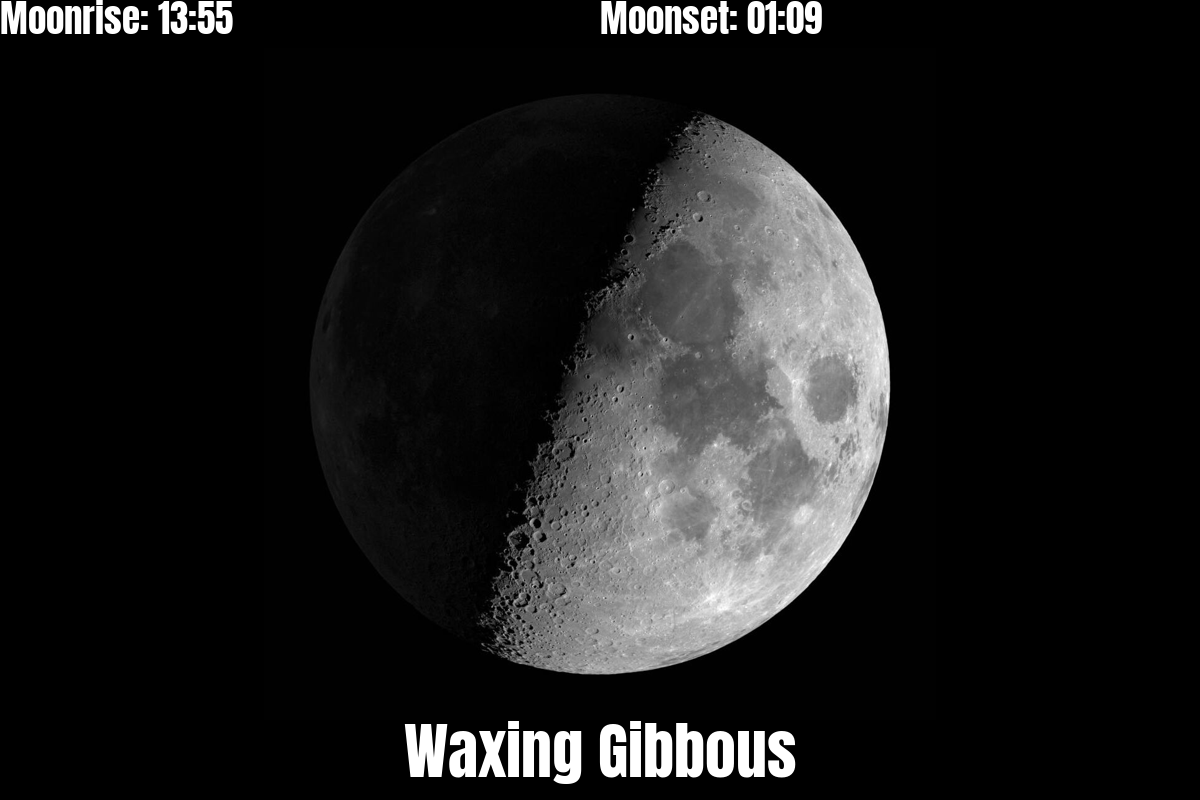

In [158]:
# this simulates calling the plugin from PaperPi
# q = my_plugin()

In [ ]:
# Jupyter notebook magic to create a symbolic to the library directory
# this will allow you to import the Plugin() module 
!ln -s ../../library ./


In [161]:
!jupyter-nbconvert --to python --template python_clean moon_phase.ipynb

[NbConvertApp] Converting notebook moon_phase.ipynb to python
[NbConvertApp] Writing 15063 bytes to moon_phase.py
